<i><b>Public AI</b></i>
<br>
# Grad-CAM이란?

### _Objective_

* Grad-CAM은 Class Activation Map의 일반화된 모델로, Global Average Pooling을 이용하지 않고 Gradient을 통해, Class Activation Map을 계산하는 방법론입니다.<br>


In [2]:
%matplotlib inline
import os
import cv2
from PIL import Image

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import get_file

## 예제 이미지) 

이번에는 강아지와 레서판다 이미지를 통해, Class Activation Map을 시각화해보도록 하겠습니다.

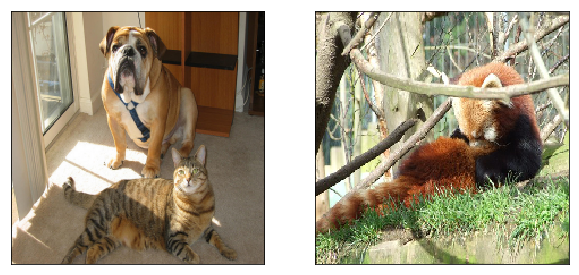

In [3]:
# 이미지 시각화하기 
dog_path = get_file("cat_and_dog.png",
                    "https://raw.githubusercontent.com/jacobgil/keras-grad-cam/master/examples/cat_dog.png")
dog_image = Image.open(dog_path)
dog_image = np.array(dog_image.resize((224,224)))

panda_path = get_file("redpanda.jpg",
                      "https://s3.ap-northeast-2.amazonaws.com/pai-datasets/alai-deeplearning/redpanda.jpg")
panda_image = Image.open(panda_path)
panda_image = np.array(panda_image.resize((224,224)))

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)
ax.set_xticks([]); ax.set_yticks([])
ax = fig.add_subplot(1,2,2)
ax.imshow(panda_image)
ax.set_xticks([]); ax.set_yticks([])
plt.show()

# \[ Grad-CAM이란? \]
---

Gradient-weighted CAM은 CAM을 보다 일반화한 시각화 방법론입니다. CAM과 달리, Inference Model을 변형하지 않고도 쓸 수 있다는 점에서 매우 유용합니다.

<br>

## 1. Grad-CAM의 아이디어



### (1) Feature Map에서의 Gradient의 의미

![Imgur](https://i.imgur.com/n3ewNlt.png)

이전 시간에 배웠던 Class Activation Map의 경우, 우리는 각 필터의 중요도를 확인하기 위해 Global Average Pooling으로 필터 별로 요약하고, 거기에 Softmax를 통해 학습을 하였습니다. <br>
대신 Grad-CAM에서는 Gradient에 주목하였습니다.

![Imgur](https://i.imgur.com/iuTUcoG.png)


국소적으로 보았을 때, 출력값은 이 기울기와 Feature Map의 선형결합으로 해석할 수 있습니다.<br>
이를 이용해, CAM 방식에서 구한 Weight 대신 이 기울기로 Weight로 삼았습니다.<br>
그래서 Gradient-Weighted CAM 방식을 일반화된 형태의 CAM 방식이라고 설명합니다.

### (2) Gradient-CAM의 구조도

![Imgur](https://i.imgur.com/BqaK7V4.png)

## 2. Grad-CAM 구현하기


* Grad-CAM은 이전의 방식과 달리, 학습이 따로 필요하지 않습니다.<br>
* 이번에도 VGG 모델을 이용해서 구현하도록 하겠습니다.<br>

### (1) VGG 모델 가져오기

In [49]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.models import Model

vgg19 = VGG19()

> Grad-CAM uses the gradient information flowing into **the last convolutional layer** of the CNN to understand the importance of each neuron for a decision of iterest.

Grad-CAM은 마지막 Convolution layer의 출력층과 마지막 Classification 결과의 기울기를 통해 중요도를 계산합니다. 이를 위해서 우리는 모델을 다시 정의해줄 필요가 있습니다.

In [51]:
fmap = # 마지막 Convolution Layer 가져오기
output = # 출력층 가져오기

grad_model = Model(vgg19.input, [fmap, output])

### (2) Grad-CAM 부분 구현하기

Grad-CAM은 아래의 수식들을 코드로 구현하면 됩니다.

* Partial Linearization($\alpha_k^C$) : 마지막 Convolution Layer의 채널별 중요도
  
  $\alpha_k^C = \frac{1}{z}\sum_{i}\sum_{j}\frac{\partial y^c}{\partial A^{k}_{ij}}$

* Grad-CAM : 
  
  $L^{C}_{\mbox{grad-cam}} = ReLU(\sum_{k} \alpha_k^cA^k)$

In [52]:
from tensorflow.keras.models import Model
import tensorflow as tf

In [53]:
image = dog_image - [123.68,116.779,103.939,]
image = image.astype(np.float32)

# TODO 

In [54]:
@tf.function
def get_gradcam_result(image):
    with tf.GradientTape() as tape:
        conv_outputs, model_outputs = grad_model(image[None])

        top_indices = tf.argmax(model_outputs, axis=1)
        top_logit = tf.gather(model_outputs, top_indices, axis=1)

    grads = tape.gradient(top_logit, conv_outputs)
    channel_importance = tf.reduce_mean(grads, axis=[1,2],
                                        keepdims=True)
    heat_map = tf.reduce_sum(channel_importance * conv_outputs, 
                             axis=-1, keepdims=True)
    heat_map = tf.nn.relu(heat_map)
    heat_map = tf.squeeze(heat_map)
    return model_outputs, tf.nn.relu(heat_map)

<Br> 
    
## 3. Grad-CAM을 통한 히트맵 시각화


### (1) Heatmap 시각화 메소드 구현하기

In [55]:
def blend_heatmap(image, heatmap, ratio=0.5):
    image = np.array(image)
    heatmap = np.array(heatmap)
    h, w = image.shape[:2]
    heatmap = cv2.resize(heatmap, (w, h))
    
    heatmap = ((heatmap - heatmap.min())/
               (heatmap.max() - heatmap.min()))
    heatmap = (heatmap * 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    heatmap = heatmap / 255.
    
    norm_image = ((image - image.min())/
                  (image.max() - image.min()))
    blend_image = (heatmap * ratio 
                   + norm_image * (1-ratio))
    return blend_image

### (2) 개 사진 시각화하기 

In [62]:
image = dog_image - [123.68,116.779,103.939,]
image = image.astype(np.float32)

prediction, heat_value = get_gradcam_result(image)
predicted_label = decode_predictions(prediction.numpy())[0]

blended_image = blend_heatmap(image, heat_value)

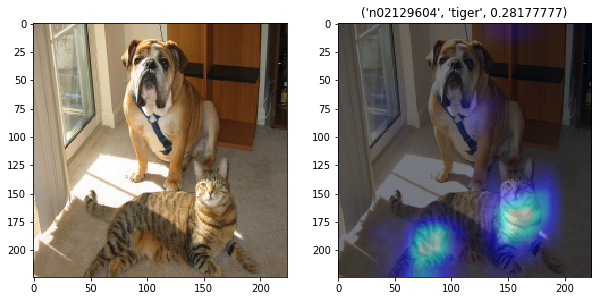

In [63]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(dog_image)

ax = fig.add_subplot(1,2,2)
ax.set_title(predicted_label[0])
ax.imshow(blended_image)
plt.show()

### (3) 레서 판다 시각화하기

In [60]:
image = panda_image - [123.68,116.779,103.939,]
image = image.astype(np.float32)

prediction, heat_value = get_gradcam_result(image)
predicted_label = decode_predictions(prediction.numpy())[0]

blended_image = blend_heatmap(image, heat_value)

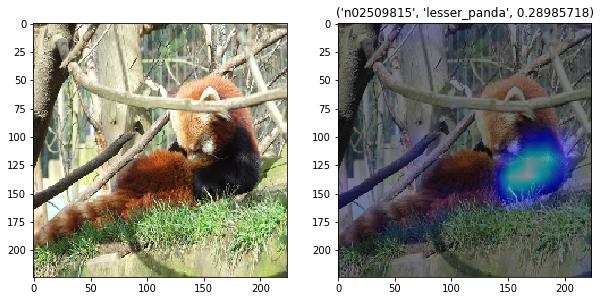

In [61]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,2,1)
ax.imshow(panda_image)

ax = fig.add_subplot(1,2,2)
ax.set_title(predicted_label[0])
ax.imshow(blended_image)
plt.show()


### Exercise 1) RESNET에 Grad-CAM을 적용해보기



In [ ]:
from tensorflow.keras.applications import ResNet101

### Exercise 2) 상위 3개에 대한 출력값 모두 Grad-CAM을 적용하여 시각화하기

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.<br>
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/05/14

---